# Spectrum CNN

Automatic modulation recognition with CNN using spectrogram data based on technique from Zeng et al's paper "Spectrum Analysis and Convolutiopnal Neural Netowrk for Automatic Modulation Recognition" published in IEEE Wireless Communications Letters, Vol 8, No 3, of June 2019.

This example deviates from Zeng et al's in tje following ways:

- Spectrogram data (CNN input) is provided as a 2D (time and freqnency) array of intensity values as apposed to a 3D (time, frequency, and three color channels) array. This allows Conv2D layers to be used vs Conv3D. This change reduces the number of learned parameters from 199k to 172k.


- The dataset combines spectrograms from multiple SNRs (0 to 18 dB) vs only using a single SNR per model. This is inteded to make the trained model more robust to noise by 1) providing more training data, and 2) providing a wider variety of data due to various ammounts of noise present.

In [26]:
import sys
sys.path.append("../modules")

import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation


import utilities as ut
import preprocess

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

The following cell can be run to reload the iq_utils modlue after editing during notebook testing

In [ ]:
from importlib import reload
reload(ut)
reload(preprocess)

## Load data

In [19]:
spec_dict = ut.from_pickle('../processed_data/spectrogram_dict_MPh')

In [20]:
X_train, y_train, X_test, y_test = preprocess.process_data(spec_dict, test_split=0.0, blur=False)

In [21]:
print('There are {} samples in the trianing set and {} in the testing set'.format(X_train.shape[0], X_train.shape[0]))

There are 55000 samples in the trianing set and 55000 in the testing set


## Build model

In [27]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(12, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 64)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)       

## Train model
Zeng et al does not discuss the size of batches used or if overfitting occured

In [29]:
history_mag = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.1, verbose=1)

Train on 49500 samples, validate on 5500 samples
Epoch 1/20
49500/49500 [==============================] - 30s 608us/sample - loss: 1.1888 - accuracy: 0.5042 - val_loss: 23.3692 - val_accuracy: 0.0882
Epoch 2/20
49500/49500 [==============================] - 30s 608us/sample - loss: 0.8213 - accuracy: 0.6297 - val_loss: 12.7095 - val_accuracy: 0.1609
Epoch 3/20
49500/49500 [==============================] - 31s 635us/sample - loss: 0.6602 - accuracy: 0.6915 - val_loss: 0.8996 - val_accuracy: 0.6176
Epoch 4/20
49500/49500 [==============================] - 33s 676us/sample - loss: 0.5903 - accuracy: 0.7163 - val_loss: 1.0284 - val_accuracy: 0.6349
Epoch 5/20
49500/49500 [==============================] - 37s 752us/sample - loss: 0.5491 - accuracy: 0.7328 - val_loss: 0.5365 - val_accuracy: 0.7480
Epoch 6/20
49500/49500 [==============================] - 42s 843us/sample - loss: 0.5272 - accuracy: 0.7413 - val_loss: 0.7472 - val_accuracy: 0.6545
Epoch 7/20
49500/49500 [===================

## View training stats

In [30]:
history_magphase = history_mag

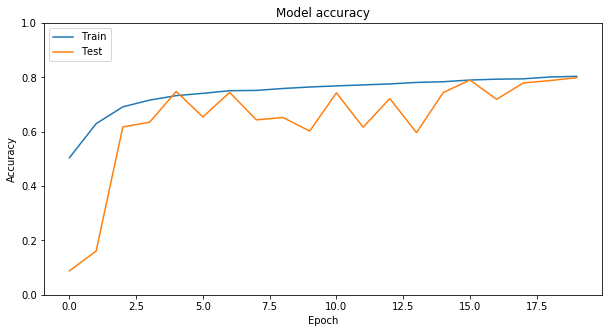

In [31]:
plt.plot(history_magphase.history['accuracy'])
plt.plot(history_magphase.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

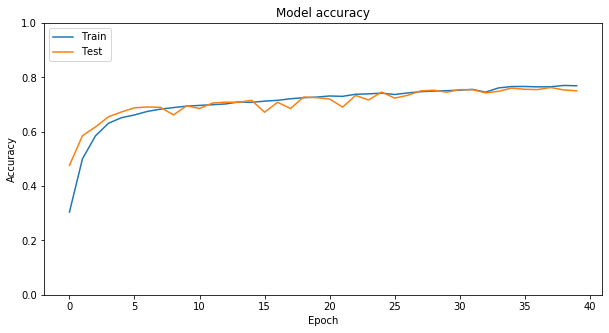

In [11]:
plt.plot(history_IQ.history['accuracy'])
plt.plot(history_IQ.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

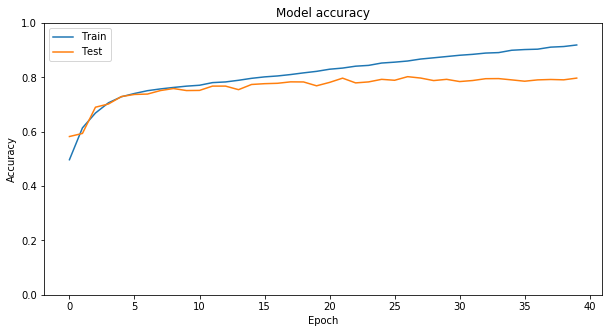

In [8]:
plt.plot(history_MPh.history['accuracy'])
plt.plot(history_MPh.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

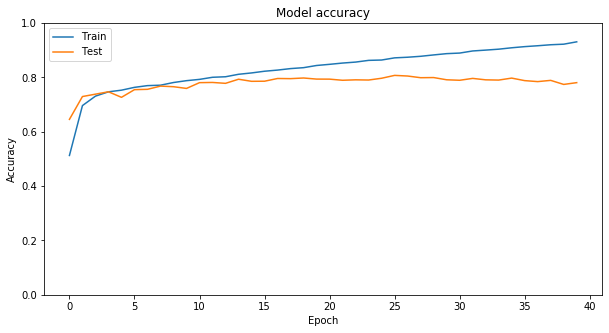

In [18]:
plt.plot(history_mag.history['accuracy'])
plt.plot(history_mag.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluate model
TODO: this uses the training data as no seperate test data was set aside. There was discussion online about this, need to look into if further.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=128)
print("Loss:\t\t{}\nAccuracy:\t{}".format(loss, accuracy))

## Save model

In [32]:
model.save('cSCNNmp_10_18.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cSCNNmp_10_18.model/assets


## Load model

In [ ]:
model = tf.keras.models.load_model('SCNN_0_18.model')

In [ ]:
model.summary()